In [74]:
import tensorflow as tf
from keras.layers import Dense,Conv2D,Conv2DTranspose,Input,BatchNormalization,MaxPooling2D,Flatten,Reshape,LeakyReLU
from keras.models import Model
import numpy as np
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)

In [151]:
def encoder(shape):
  inputs = Input(shape=shape)
  x = Conv2D(3,(3,3),padding='same',activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.001)(x)
  x = MaxPooling2D()(x)
  x = Conv2D(3,(3,3),padding='same',activation='relu')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.001)(x)
  x = MaxPooling2D()(x)
  x = Conv2D(3,(3,3),padding='same',activation='relu')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.001)(x)
  x = MaxPooling2D()(x)
  x = Flatten()(x)
  mean = Dense(2)(x)
  var = Dense(2)(x)
  model = Model(inputs,[mean,var])
  return model

In [150]:
def decoder(shape):
  inputs = Input(shape=shape)
  x = Dense(49)(inputs)
  x = Reshape((7,7,1))(x)
  x = Conv2DTranspose(3,(3,3),strides=2,padding='same',activation='relu')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.001)(x)
  x = Conv2DTranspose(1,(3,3),strides=2,padding='same',activation='relu')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.001)(x)
  model = Model(inputs,x)
  return model

In [178]:
def sampling(mean,var):
  batch = mean.shape[0]
  dim = mean.shape[1]
  epsilon = np.random.randn(batch,dim)
  return mean + K.exp(0.5 *var) * epsilon

In [179]:
def AllLoss(images,reconImages,mean,var):
  ReconstructionLoss = recon(images,reconImages)
  similarityLoss = KLDiv(mean,var)
  return 1000*ReconstructionLoss + similarityLoss

def recon(images,reconImages):
  return K.mean(K.square(images-reconImages),axis=[1,2,3]) #mse

def KLDiv(mean,var):
  return -0.5 * K.sum(1+var-K.square(mean)-K.exp(var),axis=1)

In [180]:
class Vae(keras.Model):
  def __init__(self,encoder,decoder,**kwargs):
    super(Vae, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  

In [181]:
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.0005)
def train_step(data):
    with tf.GradientTape() as tpenc , tf.GradientTape() as tpdec:
      mean,var = encoders(data)
      z = sampling(mean,var)
      reconstruction = decoders(z)
      totalLoss = AllLoss(data,reconstruction,mean,var)
      encodergrads = tpenc.gradient(totalLoss,encoders.trainable_variables)
      decodergrads = tpdec.gradient(totalLoss,decoders.trainable_variables)
      optimizers.apply_gradients(zip(encodergrads,encoders.trainable_variables))
      optimizers.apply_gradients(zip(decodergrads,decoders.trainable_variables))
      return totalLoss

In [182]:
encoders = encoder((28,28,1))
decoders = decoder((2))

In [190]:
for epoch in range(10):
  print(epoch)
  for image_batch in train_dataset:
    loss = train_step(image_batch)

0
1
2
3
4
5
6
7
8
9


In [209]:
data = next(iter(train_dataset))

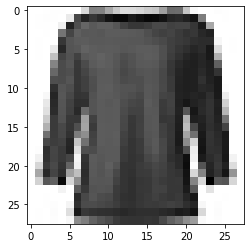

In [210]:
plt.imshow(data[0,:,:,0],cmap='Greys')

In [211]:
mean,var = encoders(data)

In [212]:
z = sampling(mean,var)

In [213]:
kon = decoders(z)

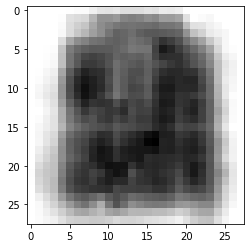

In [214]:
plt.imshow(kon[0,:,:,0],cmap='Greys')